In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [3]:
start = -7
end = 7
n = 300
batch_size = 16

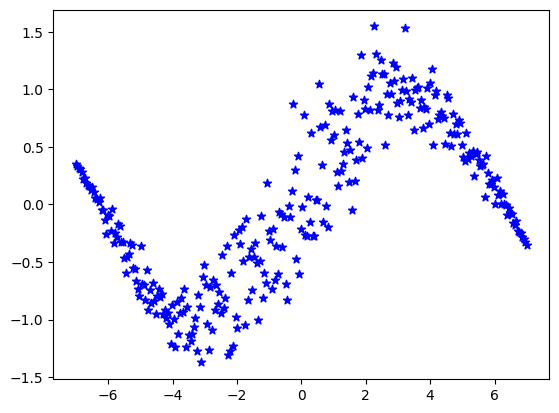

In [4]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

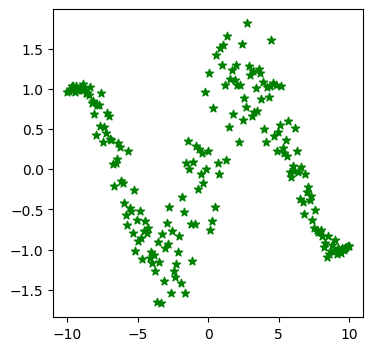

In [5]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

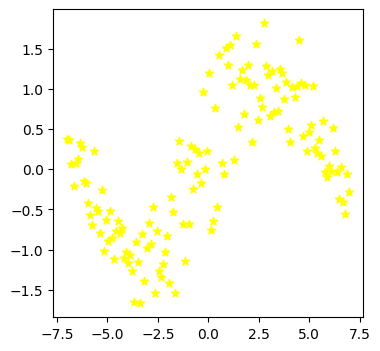

In [6]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


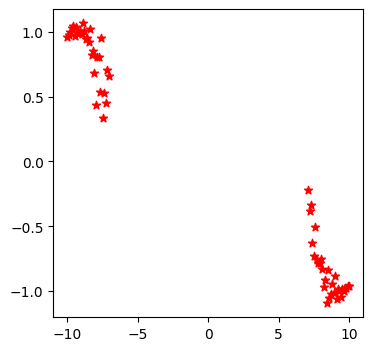

In [7]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [8]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
modelSamples = 50

In [10]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()
        self.hidden_size = 35

        # We only have 1 input feature
        self.b1 = nn.Linear(1, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size)

        self.mu = nn.Linear(self.hidden_size, 1)
        self.var = nn.Linear(self.hidden_size, 1)

    def forward(self, x):

        h = torch.tanh(self.b1(x))
        h = torch.tanh(self.b2(h))

        input_noise = torch.normal(0, 1, size=(x.shape[0], self.hidden_size))

        t           = torch.tanh(self.t1(input_noise))
        t           = torch.tanh(self.t2(t))
        prod        = torch.multiply(t,h)

        mu = self.mu(prod)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(prod))
        return mu, var

sns.set(rc={'figure.figsize':(4, 4)})
def make_plot_dpo(model):
    # Get predictions
    mus = []
    vars = []
    for m in range(modelSamples):
        mu, var = model(tensor_x_test)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)
    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []
    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()
    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)
    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*")
    plt.savefig("dpo.png", dpi=300, bbox_inches='tight')  # Add this line
    plt.show()



In [11]:
#Plot function for Out of Distribution Data
def make_plot_dpo_oodd(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test_oodd)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_oodd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.5)
    plt.show()

In [12]:
#Plot function for In Distribution Data
def make_plot_dpo_idd(model):
    # Get predictions
    mus = []
    vars = []

    for m in range(modelSamples):
        mu, var = model(tensor_x_test_idd)
        mus.append(mu)
        vars.append(var)
    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()

    # stds = torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2) + \
                torch.stack(vars).mean(axis=0).detach().numpy()**(1/2)

    mu = means
    sigma = stds
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test_idd.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.5)
    plt.show()

In [13]:
net = DeepONet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

DeepONet(
  (b1): Linear(in_features=1, out_features=35, bias=True)
  (b2): Linear(in_features=35, out_features=35, bias=True)
  (t1): Linear(in_features=35, out_features=35, bias=True)
  (t2): Linear(in_features=35, out_features=35, bias=True)
  (mu): Linear(in_features=35, out_features=1, bias=True)
  (var): Linear(in_features=35, out_features=1, bias=True)
)
Params: 3922


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
net.to(device);

In [15]:
def MLE_dopnn():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [16]:
def MLE_dopnn_idd():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo_idd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


In [17]:
def MLE_dopnn_oodd():
  net= DeepONet()
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  net.train()
  net.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
        criterionmse_train = nn.MSELoss()
        mse_train = criterionmse_train(mu, y)
    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
             criterionmse_test = nn.MSELoss()
             all_mse_test.append(criterionmse_test(mu,y).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        test_mse=sum(all_mse_test)/len(all_mse_test)
  make_plot_dpo_oodd(net)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  return loss, test_loss, mse_train, test_mse


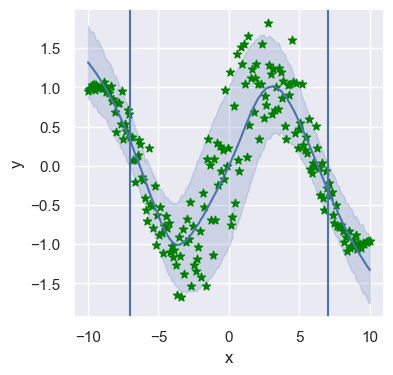

Epoch 149 | batch train loss: -1.247667908668518 | test loss: 0.17009493307425425
Epoch 149 |batch train mse:0.06008230522274971| test mse:0.14595016235342392


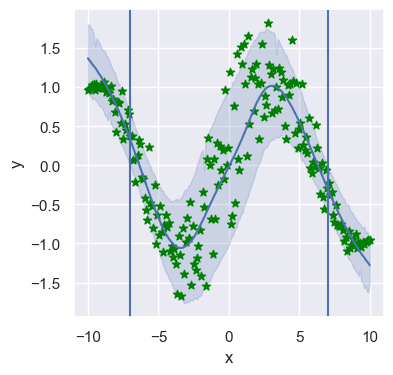

Epoch 149 | batch train loss: -1.6871699094772339 | test loss: 0.4532370882538649
Epoch 149 |batch train mse:0.010494706220924854| test mse:0.15819316013501242


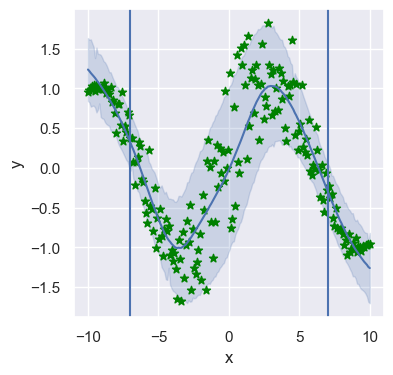

Epoch 149 | batch train loss: -1.2126219272613525 | test loss: 0.28668896624675166
Epoch 149 |batch train mse:0.050993140786886215| test mse:0.15520916850521013


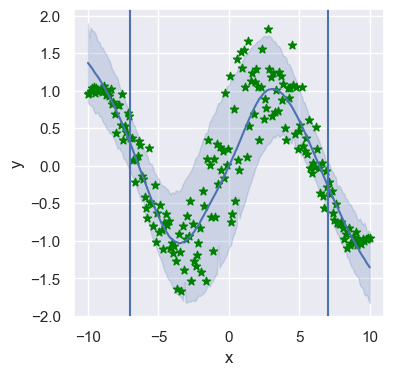

Epoch 149 | batch train loss: -1.1697615385055542 | test loss: 0.41434941383508533
Epoch 149 |batch train mse:0.05934350565075874| test mse:0.14485475134391051


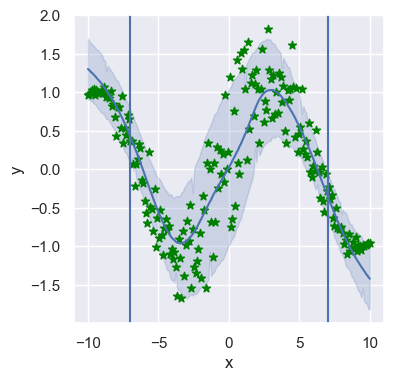

Epoch 149 | batch train loss: -1.0668549537658691 | test loss: 0.2422625720500946
Epoch 149 |batch train mse:0.0726839080452919| test mse:0.14863704087642524


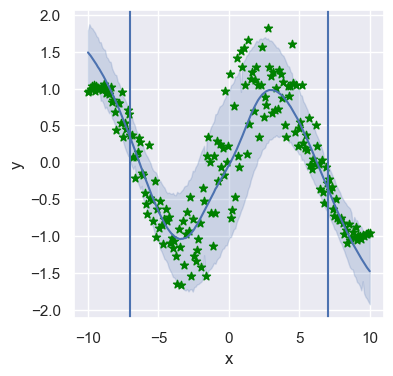

Epoch 149 | batch train loss: -1.264244794845581 | test loss: 0.43736739456653595
Epoch 149 |batch train mse:0.03941735625267029| test mse:0.1454578895981495


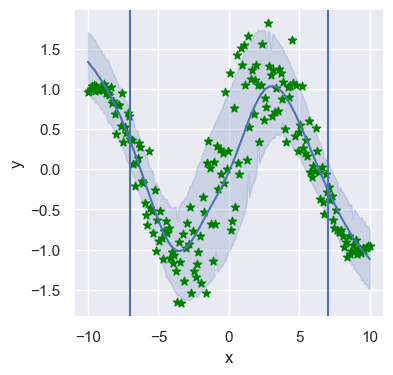

Epoch 149 | batch train loss: -1.0449074506759644 | test loss: 0.16996698941175753
Epoch 149 |batch train mse:0.04760482534766197| test mse:0.14440991299656722


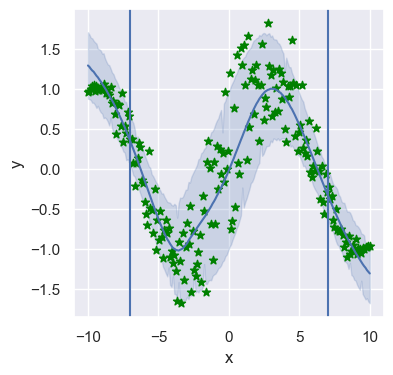

Epoch 149 | batch train loss: -1.1738232374191284 | test loss: 0.05181979617247215
Epoch 149 |batch train mse:0.06333314627408981| test mse:0.13866048506819284


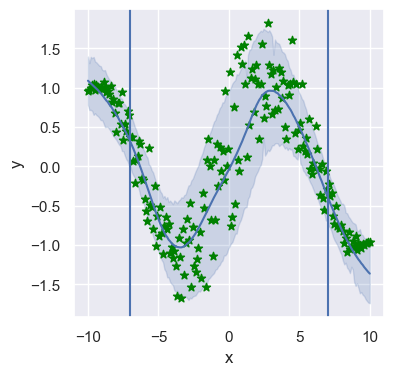

Epoch 149 | batch train loss: -0.6449345946311951 | test loss: 0.26804395020008087
Epoch 149 |batch train mse:0.07606375217437744| test mse:0.14570147372209108


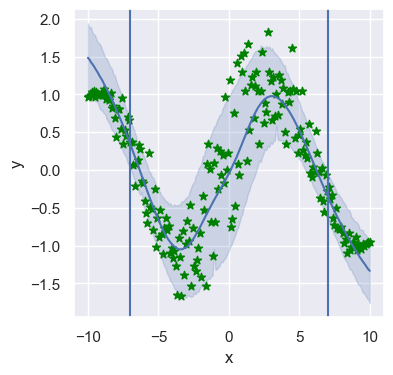

Epoch 149 | batch train loss: -1.2232913970947266 | test loss: 0.20483860144248375
Epoch 149 |batch train mse:0.0480395145714283| test mse:0.13759071265275663


In [18]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)

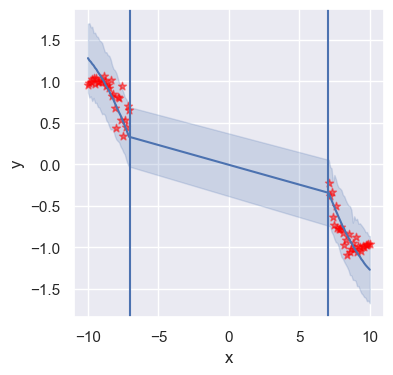

Epoch 149 | batch train loss: -1.2513617277145386 | test loss: -0.555513970553875
Epoch 149 |batch train mse:0.08845192939043045| test mse:0.03494142275303602


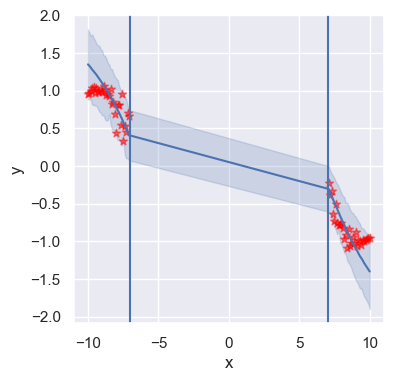

Epoch 149 | batch train loss: -1.2533485889434814 | test loss: -0.18557586008682847
Epoch 149 |batch train mse:0.06513381004333496| test mse:0.04541614931076765


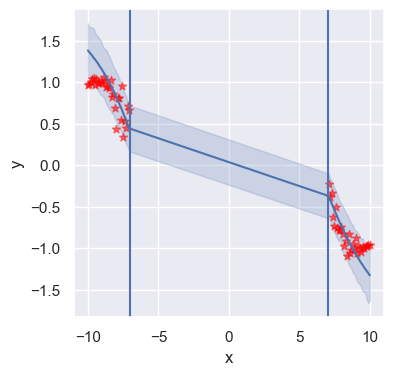

Epoch 149 | batch train loss: -1.462594985961914 | test loss: -0.7673976197838783
Epoch 149 |batch train mse:0.04241589084267616| test mse:0.03070374857634306


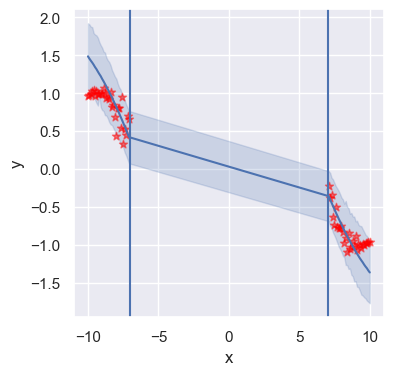

Epoch 149 | batch train loss: -1.158690094947815 | test loss: 0.05511210486292839
Epoch 149 |batch train mse:0.04735913872718811| test mse:0.049528075847774744


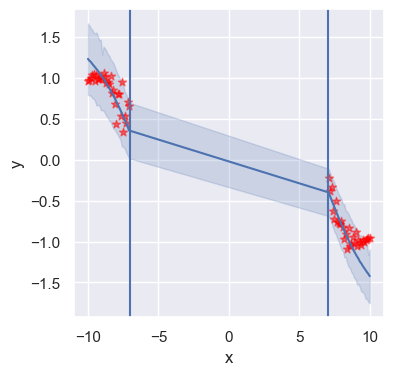

Epoch 149 | batch train loss: -0.817631721496582 | test loss: -0.7313238233327866
Epoch 149 |batch train mse:0.10438090562820435| test mse:0.031425224151462317


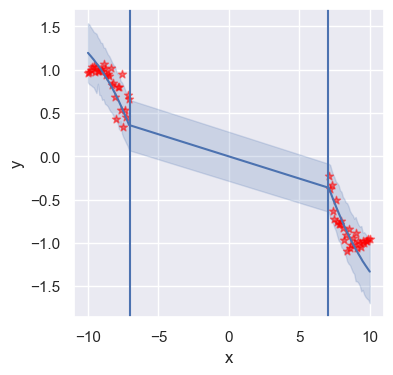

Epoch 149 | batch train loss: -1.2548624277114868 | test loss: -0.9111689329147339
Epoch 149 |batch train mse:0.07205241173505783| test mse:0.02782832272350788


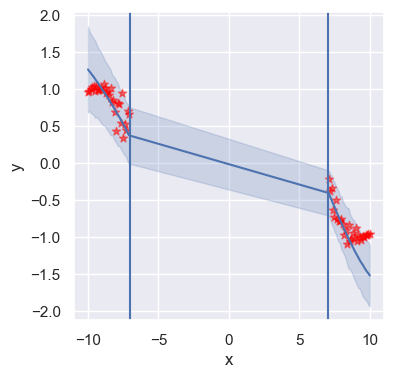

Epoch 149 | batch train loss: -1.4934617280960083 | test loss: -0.4588644877076149
Epoch 149 |batch train mse:0.0257143285125494| test mse:0.037996673956513405


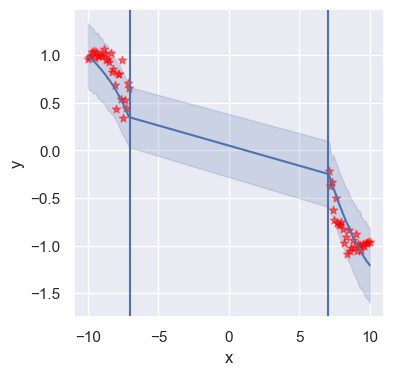

Epoch 149 | batch train loss: -0.8846072554588318 | test loss: -0.7821806222200394
Epoch 149 |batch train mse:0.06798528879880905| test mse:0.030408089514821768


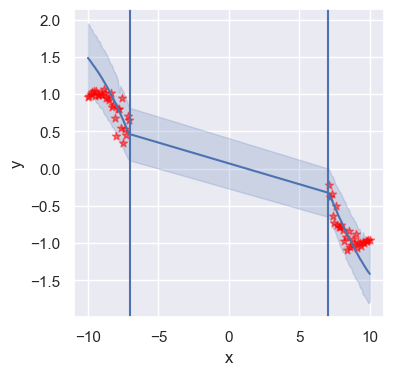

Epoch 149 | batch train loss: -1.1242551803588867 | test loss: 0.4947621747851372
Epoch 149 |batch train mse:0.03511907905340195| test mse:0.05993098486214876


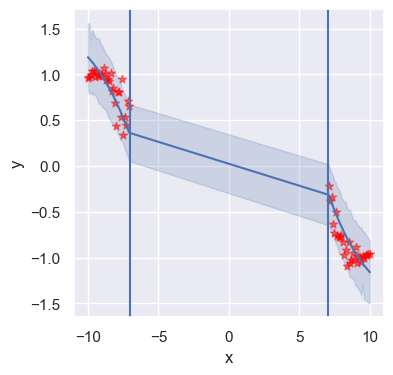

Epoch 149 | batch train loss: -1.4304052591323853 | test loss: -1.2481913566589355
Epoch 149 |batch train mse:0.03859877586364746| test mse:0.021087874891236424


In [19]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)

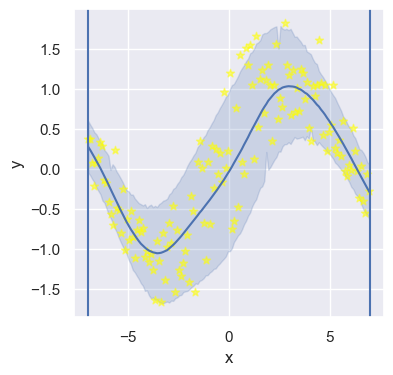

Epoch 149 | batch train loss: -0.7762768864631653 | test loss: 0.5406918194558885
Epoch 149 |batch train mse:0.09550177305936813| test mse:0.194256239467197


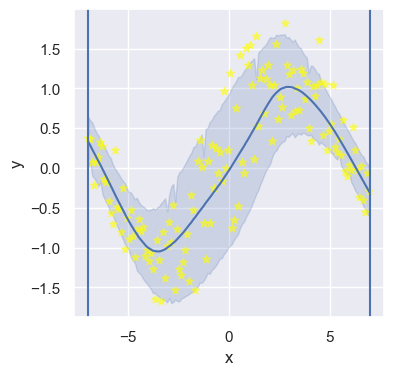

Epoch 149 | batch train loss: -1.2662698030471802 | test loss: 0.5006257345279058
Epoch 149 |batch train mse:0.037504974752664566| test mse:0.1867128478156196


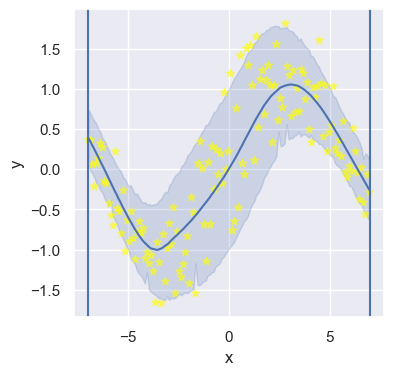

Epoch 149 | batch train loss: -1.170642375946045 | test loss: 0.606588653392262
Epoch 149 |batch train mse:0.06026318669319153| test mse:0.19213767101367316


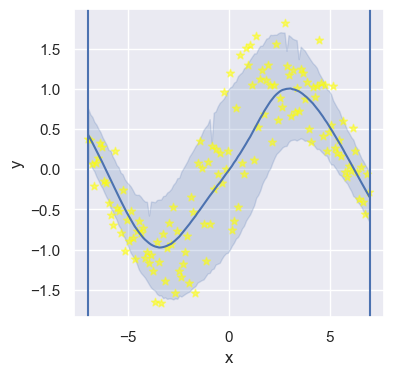

Epoch 149 | batch train loss: -0.9593179821968079 | test loss: 0.6403687807420889
Epoch 149 |batch train mse:0.08999040722846985| test mse:0.19000936879052055


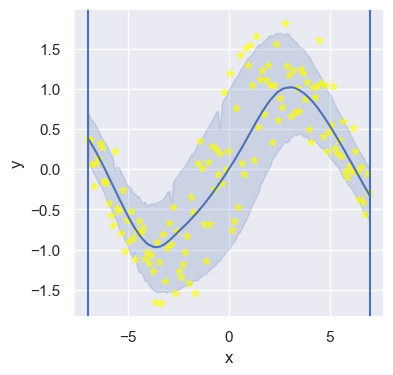

Epoch 149 | batch train loss: -1.326811671257019 | test loss: 0.7256405121750302
Epoch 149 |batch train mse:0.02118724025785923| test mse:0.20169681062301


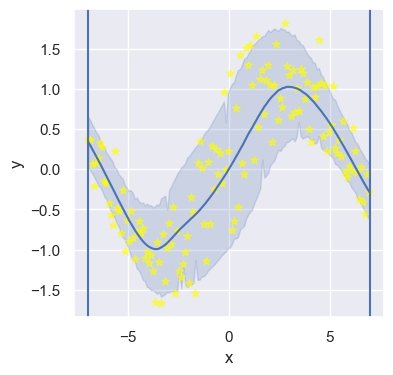

Epoch 149 | batch train loss: -1.189048171043396 | test loss: 0.3947693821456697
Epoch 149 |batch train mse:0.05025799199938774| test mse:0.1911883685323927


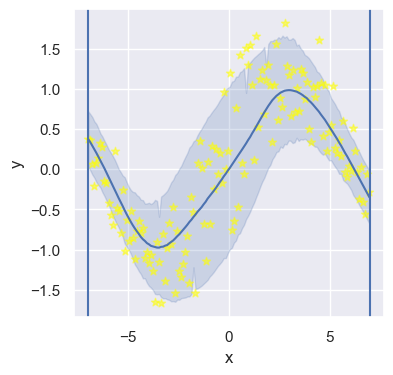

Epoch 149 | batch train loss: -1.25934636592865 | test loss: 0.6034344269169701
Epoch 149 |batch train mse:0.04731688275933266| test mse:0.19886374225219092


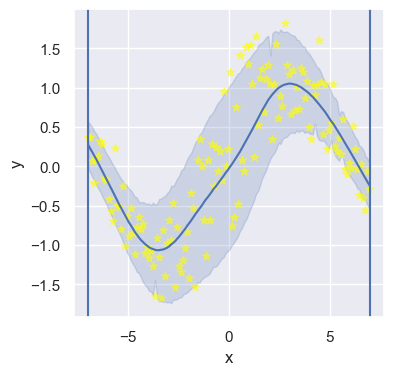

Epoch 149 | batch train loss: -1.2885318994522095 | test loss: 0.6830059736967087
Epoch 149 |batch train mse:0.03706665337085724| test mse:0.1949959604276551


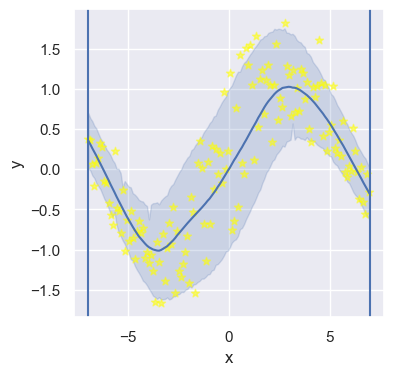

Epoch 149 | batch train loss: -1.0683155059814453 | test loss: 0.4812740120622847
Epoch 149 |batch train mse:0.0626429095864296| test mse:0.1894813146856096


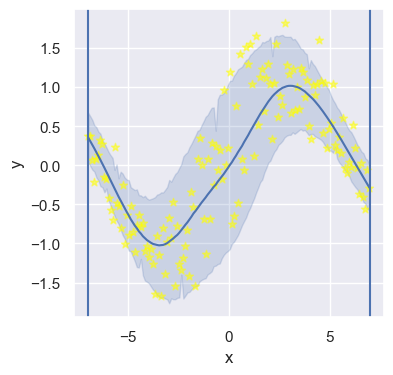

Epoch 149 | batch train loss: -0.8045719265937805 | test loss: 0.5493142712447379
Epoch 149 |batch train mse:0.07815036922693253| test mse:0.18875127865208519


In [20]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = MLE_dopnn_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)
  errors_train_idd.append(mse_tr)
  errors_test_idd.append(mse_test)

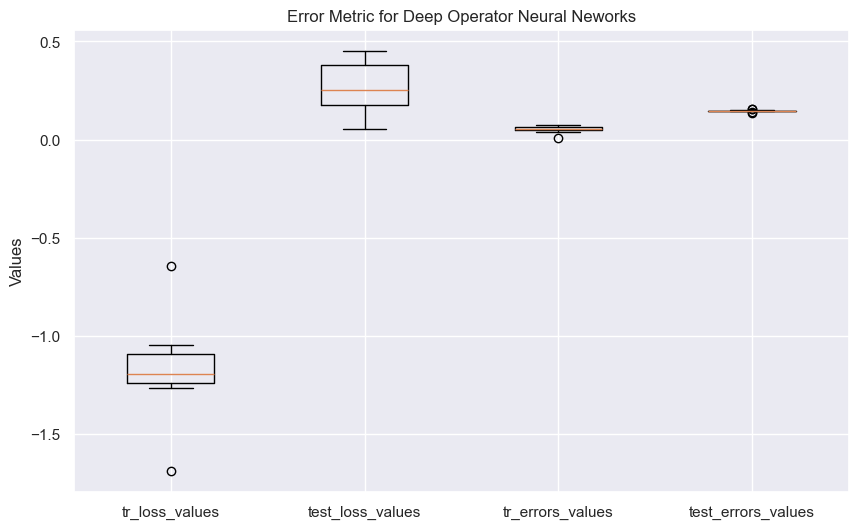

In [21]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses
tr_errors_values= [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metric for Deep Operator Neural Neworks')

# Show the plot
plt.show()


In [22]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.1735277712345122
Standard Deviation of Gausiann Training Loss of 10 runs  0.2426739893421725
Mean of Gausiann Testing Loss of 10 runs  0.2698669705253381
Standard Deviation of Gausiann Testing Loss of 10 runs  0.12462431505341405
Mean of MSE Training of 10 runs  0.052805616054683924
Standard Deviation of MSE Training of 10 runs  0.017790778768158787
Mean of MSE Testing of 10 runs  0.14646647572517396
Standard Deviation of MSE Testing of 10 runs  0.006058630017590473


In [23]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_donn.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.247668      0.170095                     0.060082   
2       -1.687170      0.453237                     0.010495   
3       -1.212622      0.286689                     0.050993   
4       -1.169762      0.414349                     0.059344   
5       -1.066855      0.242263                     0.072684   
6       -1.264245      0.437367                     0.039417   
7       -1.044907      0.169967                     0.047605   
8       -1.173823      0.051820                     0.063333   
9       -0.644935      0.268044                     0.076064   
10      -1.223291      0.204839                     0.048040   

    Mean Squared Testing Error  
1                     0.145950  
2                     0.158193  
3                     0.155209  
4                     0.144855  
5                     0.148637  
6                     0.145458  
7                     0.144410  
8                     0.138660 

In [24]:
print(test_errors_values)

[0.14595016235342392, 0.15819316013501242, 0.15520916850521013, 0.14485475134391051, 0.14863704087642524, 0.1454578895981495, 0.14440991299656722, 0.13866048506819284, 0.14570147372209108, 0.13759071265275663]
